In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
import cv2
import os

In [2]:
import keras
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau
from keras.utils import np_utils
from keras import backend as K


Using TensorFlow backend.


In [3]:
import tensorflow as tf
from tensorflow.python.tools import freeze_graph, optimize_for_inference_lib

from sklearn.model_selection import train_test_split

# how many images to process before applying gradient correction
batch_sz = 32

# how many times the network should train on the whole dataset
nb_epoch = 50

# how many images to generate per image in datasets
nb_gen = 20

In [4]:
# create path if not exists
def create_ifnex(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# exit program is path if not exists
def exit_ifnex(directory):
    if not os.path.exists(directory):
        print(directory, 'does not exist')
        exit()


In [5]:
width, height, channel = 300, 280, 1
grayscale = True
dataset_folder = './gestures'
file_format = 'png'


In [6]:
# loads an opencv image from a filepath
def get_img(path):
    image = cv2.imread(path, 0) if grayscale else cv2.imread(path,channel)
    image = cv2.resize(image, (width, height))
    image = img_to_array(image)
    image = image.reshape(width, height, channel)
    return image

In [7]:
def generate_data(path):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    classesFolders = os.listdir(path)
    for folder in classesFolders:
        files = os.listdir(os.path.join(path, folder))
        for fl in files:
            img = get_img(os.path.join(path, folder, fl))
            img = img.reshape(1, width, height, channel)
            i = 0
            for batch in datagen.flow(img, batch_size=1, save_to_dir=os.path.join(path, folder), save_prefix='genfile', save_format=file_format):
                i += 1
                if i > nb_gen:
                    break

In [8]:
def load_data(dataset_path):
    x_data = []
    y_data = []
    labels = []

    classes = os.listdir(dataset_path)
    for i in range(len(classes)):
        files = os.listdir(os.path.join(dataset_path, classes[i]))
        labels.append(classes[i])
        for fl in files:
            x_data.append(get_img(os.path.join(dataset_path, classes[i], fl)))
            y_data.append(i)

    x_data = np.array(x_data, dtype="float") / 255.0
    y_data = np.array(y_data)

    y_data = keras.utils.np_utils.to_categorical(y_data)
    return x_data, y_data, labels


In [9]:
# split dataset into training and testing
def split_dataset(x_data, y_data):
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1, shuffle=True)
    return x_train, y_train, x_test, y_test



In [17]:
# build convolutional neural network
def build_model(nb_classes):
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=[width,height,channel]))
    model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
    model.add(Dropout(0.5))
    model.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
    model.add(Dropout(0.5))
    model.add(Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))

    return model

In [11]:
# train model with data
def train(model, x_train, y_train):
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
    history = model.fit(x_train, y_train, batch_size=batch_sz, epochs=nb_epoch, verbose=1, validation_split=0.3)
    return history

In [12]:
# save network model and network weights into files
def save_model(model, network_path):
    create_ifnex(network_path)
    open(os.path.join(network_path, 'architecture.json'), 'w').write(model.to_json())
    model.save_weights(os.path.join(network_path, 'weights.h5'), overwrite=True)

In [13]:
# load network model and network weights from files
def read_model(network_path):
    exit_ifnex(network_path)
    model = model_from_json(open(os.path.join(network_path, 'architecture.json')).read())
    model.load_weights(os.path.join(network_path, 'weights.h5'))
    return model

In [14]:
def plot_history(history):
    #  Accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # Loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [15]:
# export model for mobile devices (tensorflow lite)
def export_model_for_mobile(dst, model_name, input_node_name, output_node_name):
    tf.train.write_graph(K.get_session().graph_def, dst, \
        model_name + '_graph.pbtxt')

    tf.train.Saver().save(K.get_session(), dst + '/' + model_name + '.chkp')

    freeze_graph.freeze_graph(dst + '/' + model_name + '_graph.pbtxt', None, \
        False, dst + '/' + model_name + '.chkp', output_node_name, \
        "save/restore_all", "save/Const:0", \
        dst + '/frozen_' + model_name + '.pb', True, "")

    input_graph_def = tf.GraphDef()
    with tf.gfile.Open(dst + '/frozen_' + model_name + '.pb', "rb") as f:
        input_graph_def.ParseFromString(f.read())

    output_graph_def = optimize_for_inference_lib.optimize_for_inference(
            input_graph_def, [input_node_name], [output_node_name],
            tf.float32.as_datatype_enum)

    with tf.gfile.FastGFile(dst + '/tensorflow_lite_' + model_name + '.pb', "wb") as f:
        f.write(output_graph_def.SerializeToString())

Train on 77 samples, validate on 33 samples
Epoch 1/50
77/77 [==============================] - 116s 2s/step - loss: 4.0097 - acc: 0.4156 - val_loss: 6.9291 - val_acc: 0.3636
Epoch 2/50
77/77 [==============================] - 86s 1s/step - loss: 7.4304 - acc: 0.4286 - val_loss: 1.0886 - val_acc: 0.3636
Epoch 3/50
77/77 [==============================] - 86s 1s/step - loss: 0.8927 - acc: 0.6234 - val_loss: 0.9511 - val_acc: 0.3939
Epoch 4/50
77/77 [==============================] - 84s 1s/step - loss: 0.8147 - acc: 0.5974 - val_loss: 0.7296 - val_acc: 0.9394
Epoch 5/50
77/77 [==============================] - 84s 1s/step - loss: 0.3586 - acc: 0.8961 - val_loss: 0.3854 - val_acc: 0.9394
Epoch 6/50
77/77 [==============================] - 83s 1s/step - loss: 0.1958 - acc: 0.9221 - val_loss: 0.3998 - val_acc: 0.7879
Epoch 7/50
77/77 [==============================] - 84s 1s/step - loss: 0.3820 - acc: 0.8831 - val_loss: 0.2882 - val_acc: 0.9394
Epoch 8/50
77/77 [===========================

Instructions for updating:
Use tf.gfile.GFile.
INFO:tensorflow:Restoring parameters from ../out/convnet.chkp
INFO:tensorflow:Froze 10 variables.
INFO:tensorflow:Converted 10 variables to const ops.
13/13 [==============================] - 4s 297ms/step
Accuracy: 100.00%


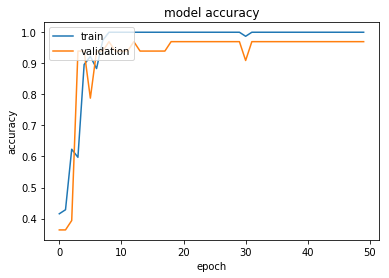

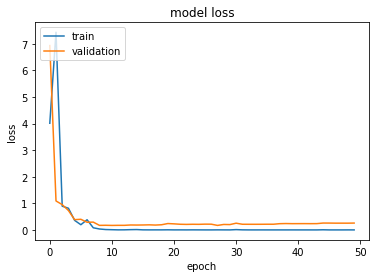

In [18]:
# generate data
#generate_data(dataset_folder)

    # Load data, split data
x_data, y_data, labels = load_data(dataset_folder)
x_train, y_train, x_test, y_test = split_dataset(x_data, y_data)

    # Create network, train it, save it
nb_classes = len(os.listdir(dataset_folder))
model = build_model(nb_classes)
history = train(model, x_train, y_train)
model.summary()
save_model(model, '../model')

    # Export model for tensorflow lite + write labels
export_model_for_mobile('../out', 'convnet', "conv2d_1_input", "dense_2/Softmax")
fl = open('../out/labels.txt', 'w')
for item in labels:
    fl.write("%s\n" % item)

    # Evaluate model on test data
scores = model.evaluate(x_test, y_test)
print("Accuracy: %.2f%%" % (scores[1]*100))

    # display graphs
plot_history(history)